## Multimodal Retrieval Augmented Generation (RAG) with ImageBind

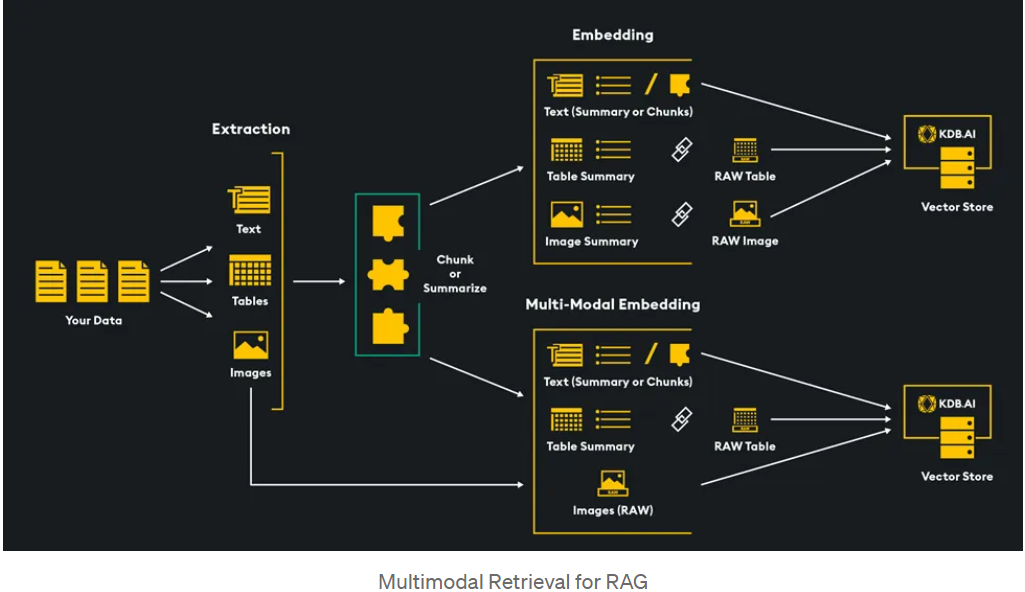

Esse notebook é baseado em um mix de artigos que encontrei. A imagem acima mostra duas possibilidades para se tratar mais de um tipo de dado, no nosso caso imagem e texto. A ideia aqui é utilizar o approach de Multi-Modal Embedding. Onde criamos embeddings tanto para texto quanto para imagens, e armazenamos num vectordb.

O modelo acima mostra o KDB AI como banco de vetores, porém da pra fazer com o ChromaDB também.

### Imports

In [1]:
import requests
import os
from PIL import Image
import io
import pandas as pd
import torch


from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

/home/joaocosentino/.pyenv/versions/user_manual/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joaocosentino/.pyenv/versions/user_manual/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/joaocosentino/.pyenv/versions/user_manual/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


#### Instanciando o modelo

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = imagebind_model.imagebind_huge(pretrained=False)

In [3]:
state_dict = torch.load(f"{os.getcwd()}/.checkpoints/imagebind_huge.pth", map_location=torch.device(device))

: 

In [4]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
model.eval()
model.to(device)

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

#### Embeddings: Text & Image

In [6]:
# Funções pra criar os embeddings
def getEmbeddingVector(inputs):
    with torch.no_grad():
        embedding = model(inputs)
    for key, value in embedding.items():
        vec = value.reshape(-1)
        vec_cpu = vec.cpu()
        vec = vec_cpu.numpy()
        return(vec)

def dataToEmbedding(dataIn,dtype):
    if dtype == 'image':
        data_path = [dataIn]
        inputs = {
        ModalityType.VISION: data.load_and_transform_vision_data(data_path, device)
        }
    elif dtype == 'text':
        txt = [dataIn]
        inputs = {
        ModalityType.TEXT: data.load_and_transform_text(txt, device)
        }
    vec = getEmbeddingVector(inputs)
    return(vec)

# Helper function to create a query vector from a natural language query
def queryToEmbedding(text):
    text = [text]
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text, device)
    }
    vec = getEmbeddingVector(inputs)
    return(vec)

### Dataframes to insert embeddings data

In [17]:
columns = ['path','media','embeddings']
df = pd.DataFrame(columns=columns)

### Load PDF Data

#### Loading Text

In [8]:
# Code to view content
from IPython.display import display, Markdown
def view_text_in_markdown(page_content):
    display(Markdown(page_content))

In [14]:
local_path = "../pdf_files/owner_manual_full.pdf"
short_pdf = "../pdf_files/owner_manual_p283-p300.pdf"
# Local PDF file uploads
if short_pdf:
  loader = UnstructuredPDFLoader(file_path=short_pdf)
  pdf_data = loader.load()
else:
  print("Upload a PDF file")

In [15]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)
chunks = text_splitter.split_documents(pdf_data)

In [19]:
media = 'text'
for chunk in chunks:

    embeddings = dataToEmbedding(chunk.page_content,media)
    new_row = {#'path': path
               'media': media,
               "embeddings":embeddings}
    df = pd.concat([df,pd.DataFrame([new_row])],ignore_index=True)

In [13]:
#Salvando os embeddings para não ter que toda vez refazer
df.to_csv('embeddins.csv')

#### Loading Images


In [21]:
images = os.listdir("../images")

In [23]:
media = 'image'
for image in images:
    path = '../images/'+ image
    embeddings = dataToEmbedding(path,media)
    new_row = {#'path':path,
               'media': media,
               'embeddings': embeddings}
    df = pd.concat([df,pd.DataFrame([new_row])],ignore_index=True)

: 